In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, add_image, FontManager
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image 
from urllib.request import urlopen
from urllib.error import HTTPError
import ScraperFC as sfc

sofascore = sfc.Sofascore()

#URL_MATCH = "https://www.sofascore.com/huachipato-cobreloa/jnbsonb#11986410"
#URL_MATCH = "https://www.sofascore.com/metropolitanos-zamora/MzcsFZob#11046611"
URL_MATCH = "https://www.sofascore.com/boca-juniors-fluminense/lOscob#11716722"


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13488\4057607167.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\USUARIO\.virtualenvs\resumenes_estadisticos-gP1gJ5q3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generar el grafico de ejemplo

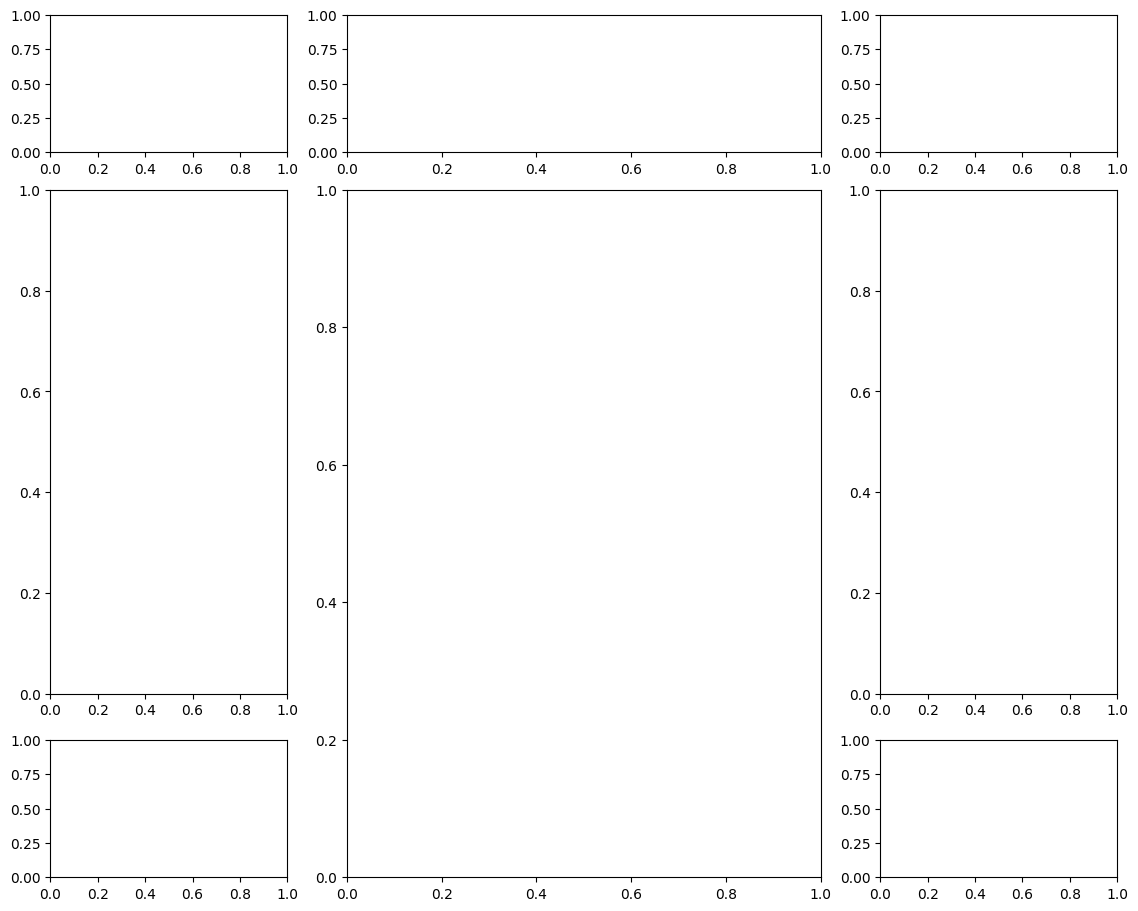

In [2]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# escudo local
ax1 = fig.add_subplot(gs[0,0:1])

# escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])

ax3 = fig.add_subplot(gs[0,1:3])

# equipo local
ax6 = fig.add_subplot(gs[1:4,:1])

ax10 = fig.add_subplot(gs[4:,:1])

# info partido
ax7 = fig.add_subplot(gs[1:,1:3])

# equipo visitante
ax8 = fig.add_subplot(gs[1:4,3:4])

ax9 = fig.add_subplot(gs[4:,3:4])



### Agregar la fuente

In [3]:
fuente1 = FontManager("https://github.com/google/fonts/blob/main/ofl/abeezee/ABeeZee-Regular.ttf?raw=true")

### Obtener informacion del partido

In [4]:
partido_sofascore = sofascore.get_match_data(URL_MATCH)
nombre_local, nombre_visit = sofascore.get_team_names(URL_MATCH)
estadisticas_partido = sofascore.get_general_match_stats(URL_MATCH)

df_local, df_visit = sofascore.get_players_match_stats(URL_MATCH)



### Obtener los jugadores destacados en esas metricas

In [5]:
lista_mayores = ['duelWon', 'touches', 'keyPass', 'accuratePass'] # hay ligas que no tienen xG ni xA
nombre_mayores_local = []
valor_mayores_local = []
nombre_mayores_visit = []
valor_mayores_visit = []

# equipo local
for i in range(len(lista_mayores)):
    nombre = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_local.append(nombre)
    valor_mayores_local.append(valor)
    
# equipo visitante
for i in range(len(lista_mayores)):
    nombre = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_visit.append(nombre)
    valor_mayores_visit.append(valor)
    
nombre_mayores_local, valor_mayores_local

(['Ezequiel Fernández', 'Pol Fernández', 'Pol Fernández', 'Pol Fernández'],
 [9.0, 97.0, 4.0, 75.0])

### Obtener imagen del jugador destacado de cada equipo

In [6]:
jugador_destacado_local = df_local[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
jugador_destacado_visit = df_visit[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
id_jug_local = df_local[df_local['name'] == jugador_destacado_local].id.values[0]
id_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].id.values[0]

try:
  imagen_jug_local = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_local}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_local = ''

try:
  imagen_jug_visit = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_visit}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_visit = ''


### Sacar inforamcion de cada jugador

In [7]:
df_jug_local = df_local[df_local['name'] == jugador_destacado_local]
df_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit]


### obtener informacion de los equipos

In [8]:
# id equipos
idlocal = partido_sofascore['homeTeam']['id']
idvisit = partido_sofascore['awayTeam']['id']

# escudos de los equipos
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

# goles de los equipos
goleslocal = partido_sofascore['homeScore']['normaltime']
golesvisit = partido_sofascore['awayScore']['normaltime']


### Sacar info de la jornada

In [9]:
torneo = partido_sofascore['season']['name']
fecha = partido_sofascore['roundInfo']['round']

f'{nombre_local} - {nombre_visit}'

'Boca Juniors - Fluminense'

### Quitar las lineas de los plots

In [10]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Obtener estadísticas de cada equipo por separado

In [11]:
listas_estadisticas_partido = ['Expected goals', 'Ball possession', 'Total shots', 'Shots on target', 'Corner kicks', 'Fouls', 'Yellow cards', 'Red cards', 'Counter attacks', 'Goalkeeper saves']
# si no tiene xG lo quita
listas_estadisticas_partido = [elemento for elemento in listas_estadisticas_partido if elemento != 'Expected goals' or 'Expected goals' in estadisticas_partido['name'].to_list()]
lista_valores_partido_local = []
lista_valores_partido_visit = []

# equipo local
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['home'].values[0]
        lista_valores_partido_local.append(valor)
    else:
        lista_valores_partido_local.append(0)
    
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['away'].values[0]
        lista_valores_partido_visit.append(valor)
    else:
        lista_valores_partido_visit.append(0) 

### Agregar la informacion al plot

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13488\30672730.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13488\30672730.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1,.7, f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} Pases Comp.', ha='left', va='center', size=15)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13488\30672730.py:38: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1, .6, f'{int(df_jug_local["goals"])} {"Gol" if int(df_jug_local["goals"]) == 1 else "Goles"}', ha='left', va='center', size=15)

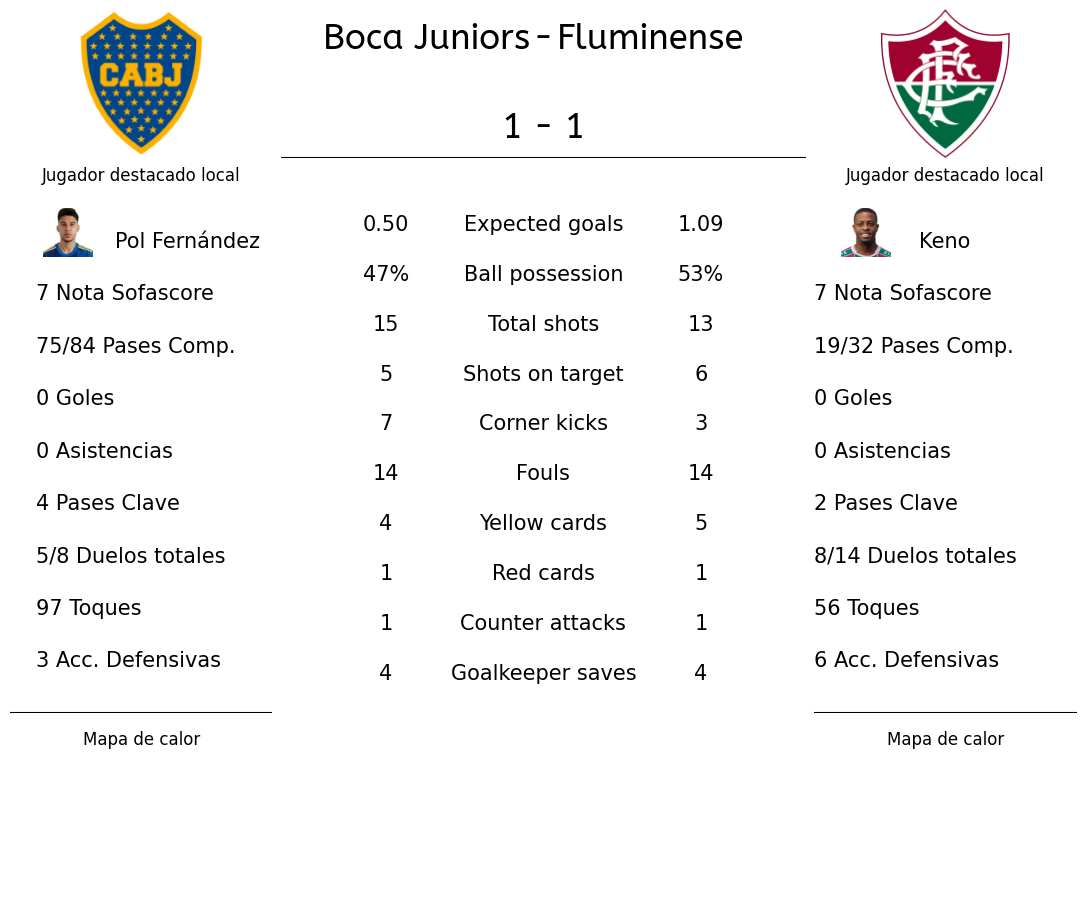

In [25]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)

# Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)

# info del partido
ax3 = fig.add_subplot(gs[0, 1:3])
ax3.text(.475, .8, f'{nombre_local}', ha='right', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.525, .8, f'{nombre_visit}', ha='left', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.5, .8, f'-', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.5, .2, f'{goleslocal} - {golesvisit}', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.axhline(0, color='black')
sacar_spines(ax3)

# pasar los valores nulos a 0
df_jug_local = df_jug_local.fillna(0)
df_jug_visit = df_jug_visit.fillna(0)

# Jugador Destacado local
ax6 = fig.add_subplot(gs[1:4, :1])
ax6.set_title('Jugador destacado local')
ax_image2 = add_image(imagen_jug_local, fig, left=0.0113, bottom=0.72, width=0.055, height=0.055) if imagen_jug_local else None
ax6.text(.4,.90, f'{jugador_destacado_local}', ha='left', va='center', size=15)
#
ax6.text(0.1,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15)
#
ax6.text(0.1,.7, f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} Pases Comp.', ha='left', va='center', size=15)
#
ax6.text(0.1, .6, f'{int(df_jug_local["goals"])} {"Gol" if int(df_jug_local["goals"]) == 1 else "Goles"}', ha='left', va='center', size=15)
#
goalsAssist = df_jug_local["goalsAssist"] if 'goalsAssist' in df_jug_local.columns else 0
ax6.text(0.1,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15)
#
keyPass = df_jug_local["keyPass"] if 'keyPass' in  df_jug_local.columns else 0
ax6.text(0.1,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15)
#
ax6.text(0.1,.3, f'{int(df_jug_local["duelWon"])}/{int(df_jug_local["duelLost"])+int(df_jug_local["duelWon"])} Duelos totales', ha='left', va='center', size=15)  
#
ax6.text(0.1, .2, f'{int(df_jug_local["touches"])} Toques', ha='left', va='center', size=15) 
#
ax6.text(0.1, .1, f'{int(df_jug_local["totalTackle"]+df_jug_local["interceptionWon"]+df_jug_local["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15) 
ax6.axhline(0, color='black')
sacar_spines(ax6)

ax10 = fig.add_subplot(gs[4:, :1])
ax10.set_title('Mapa de calor')
# agregar heatmap
sacar_spines(ax10)

# estadisticas del partido
ax7 = fig.add_subplot(gs[1:, 1:3])
i = 1.05
for n in range(len(listas_estadisticas_partido)):
    ax7.text(.5, i-.1, listas_estadisticas_partido[n], ha='center', va='center', size=15)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_local)):
    ax7.text(.2, i-.1, lista_valores_partido_local[n], ha='center', va='center', size=15)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_visit)):
    ax7.text(.8, i-.1, lista_valores_partido_visit[n], ha='center', va='center', size=15)
    i-=.07
sacar_spines(ax7)

# jugador visitante
# Jugador Destacado local
ax8 = fig.add_subplot(gs[1:4, 3:4])
ax8.set_title('Jugador destacado local')
ax_image3 = add_image(imagen_jug_visit, fig, left=0.51, bottom=0.72, width=0.055, height=0.055) if imagen_jug_visit else None
ax8.text(.4,.90, f'{jugador_destacado_visit}', ha='left', va='center', size=15)
#
ax8.text(0.1,.8, f'{int(df_jug_visit["rating"])} Nota Sofascore', ha='left', va='center', size=15)
#
ax8.text(0.1,.7, f'{int(df_jug_visit["accuratePass"])}/{int(df_jug_visit["totalPass"])} Pases Comp.', ha='left', va='center', size=15)
#
ax8.text(0.1, .6, f'{int(df_jug_visit["goals"])} {"Gol" if int(df_jug_visit["goals"]) == 1 else "Goles"}', ha='left', va='center', size=15)
#
goalsAssist = df_jug_visit["goalsAssist"] if 'goalsAssist' in df_jug_visit.columns else 0
ax8.text(0.1,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15)
#
keyPass = df_jug_visit["keyPass"] if 'keyPass' in  df_jug_visit.columns else 0
ax8.text(0.1,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15)
#
ax8.text(0.1,.3, f'{int(df_jug_visit["duelWon"])}/{int(df_jug_visit["duelLost"])+int(df_jug_visit["duelWon"])} Duelos totales', ha='left', va='center', size=15)  
#
ax8.text(0.1, .2, f'{int(df_jug_visit["touches"])} Toques', ha='left', va='center', size=15) 
#
ax8.text(0.1, .1, f'{int(df_jug_visit["totalTackle"]+df_jug_visit["interceptionWon"]+df_jug_visit["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15) 
ax8.axhline(0, color='black')
sacar_spines(ax8)

ax9 = fig.add_subplot(gs[4:, 3:4])
ax9.set_title('Mapa de calor')
# agregar heatmap
sacar_spines(ax9)